# Meteo 515 – Assignment 4 – EOF analysis¶

In [1]:
from __future__ import division, print_function
#from collections import OrderedDict
from glob import glob
#from itertools import chain

import matplotlib.colors as mplcolors
import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd
#import scipy.optimize as so
#import scipy.stats as ss
#import sklearn as skl
import statsmodels.api as sm
import xarray as xr

In [2]:
plt.style.use('bmh') # 'bmh', ggplot', 'seaborn-darkgrid'
%matplotlib notebook

## Load the data

### First, create container for the results that also does the EOF calculation

math...

In [3]:
class o(object):
    """hw4 results obj
    for one dataset, the things we want to save"""
    def __init__(self, fname, ID, dset,
                 ):
        self.fname = fname
        self.ID = ID
        self.dset = dset
        
        self.calc_eofs()
        
        
    def calc_eofs(self):
        """calc EOFs
        note that SVD method may fail. should have a fallback...
        """
        evecs, evals, pcs = np.linalg.svd(self.dset['data'].values)
        self.evecs = evecs
        self.evals = evals
        self.pcs = pcs
        
        self.evals_sum = self.evals.sum()
        self.rsqd_expl = self.evals / self.evals_sum
        
        imax = np.where(np.cumsum(self.rsqd_expl) >= 0.91)[0][0]
        self.n_retain = imax + 1 if imax <= 6 else 8

### Now apply to the datasets

In [4]:
files = sorted(glob('./data/sine_wave_data*.nc'))
lbls = ['dset {:d}'.format(x) for x in range(1, len(files)+1)]

os = []
for fname, l in zip(files, lbls):
    os.append(o(fname, l, xr.open_dataset(fname)))

## a) Plot standardized principle components (PCs)

Dividing a principle component vector by the square-root of corresponding eigenvalue normalizes it, i.e., giving a variance of 1.  

In [5]:
# Some settings used in other plots
colors = plt.cm.Dark2(np.linspace(0, 1, 8))[:8]
hspace = 0.3
figsize = (8, 7)
leg_fs = 8

<IPython.core.display.Javascript object>


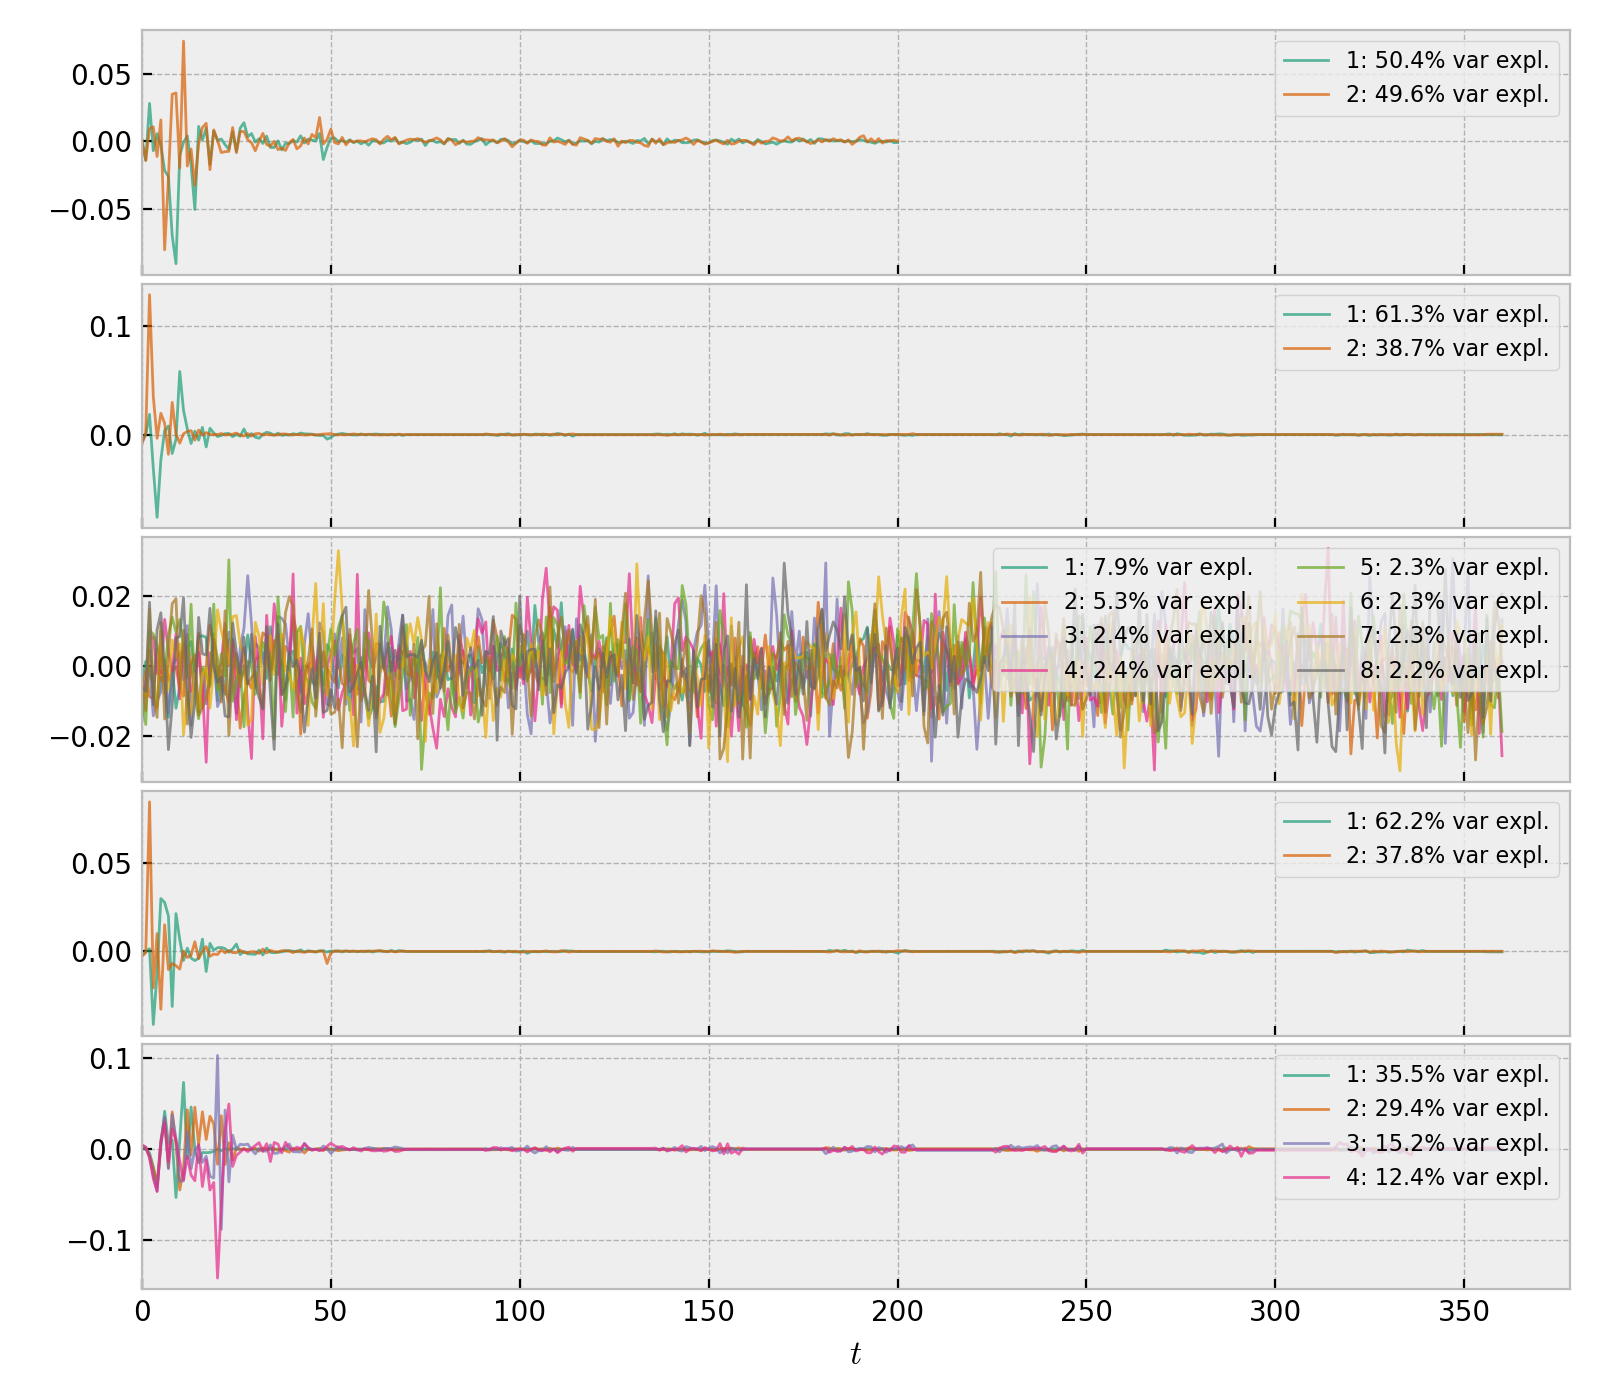

In [6]:
f1, aa = plt.subplots(len(os), 1, figsize=figsize, sharex=True, num='pcs')

for i, o in enumerate(os):
    
    a = aa.flat[i]
    
    evals = o.evals[:o.n_retain]
    pcs = o.pcs[:,:o.n_retain]
    pcts = o.rsqd_expl[:o.n_retain] * 100
    
    for j in range(pcs.shape[1]):
        s = '{:d}: {:.1f}% var expl.'.format(j+1, pcts[j])
        a.plot(pcs[:,j]/np.sqrt(evals[j]), 
               c=colors[j], lw=1.0, alpha=0.7, label=s)
    
    ncol = 1 if o.n_retain <= 4 else 2
    a.legend(loc='upper right', ncol=ncol, fontsize=leg_fs, frameon=True)

aa[0].set_xlim(left=0)
aa[-1].set_xlabel('$t$')

f1.tight_layout(h_pad=hspace);

## b) Regress the standardized PCs onto the original data

<IPython.core.display.Javascript object>


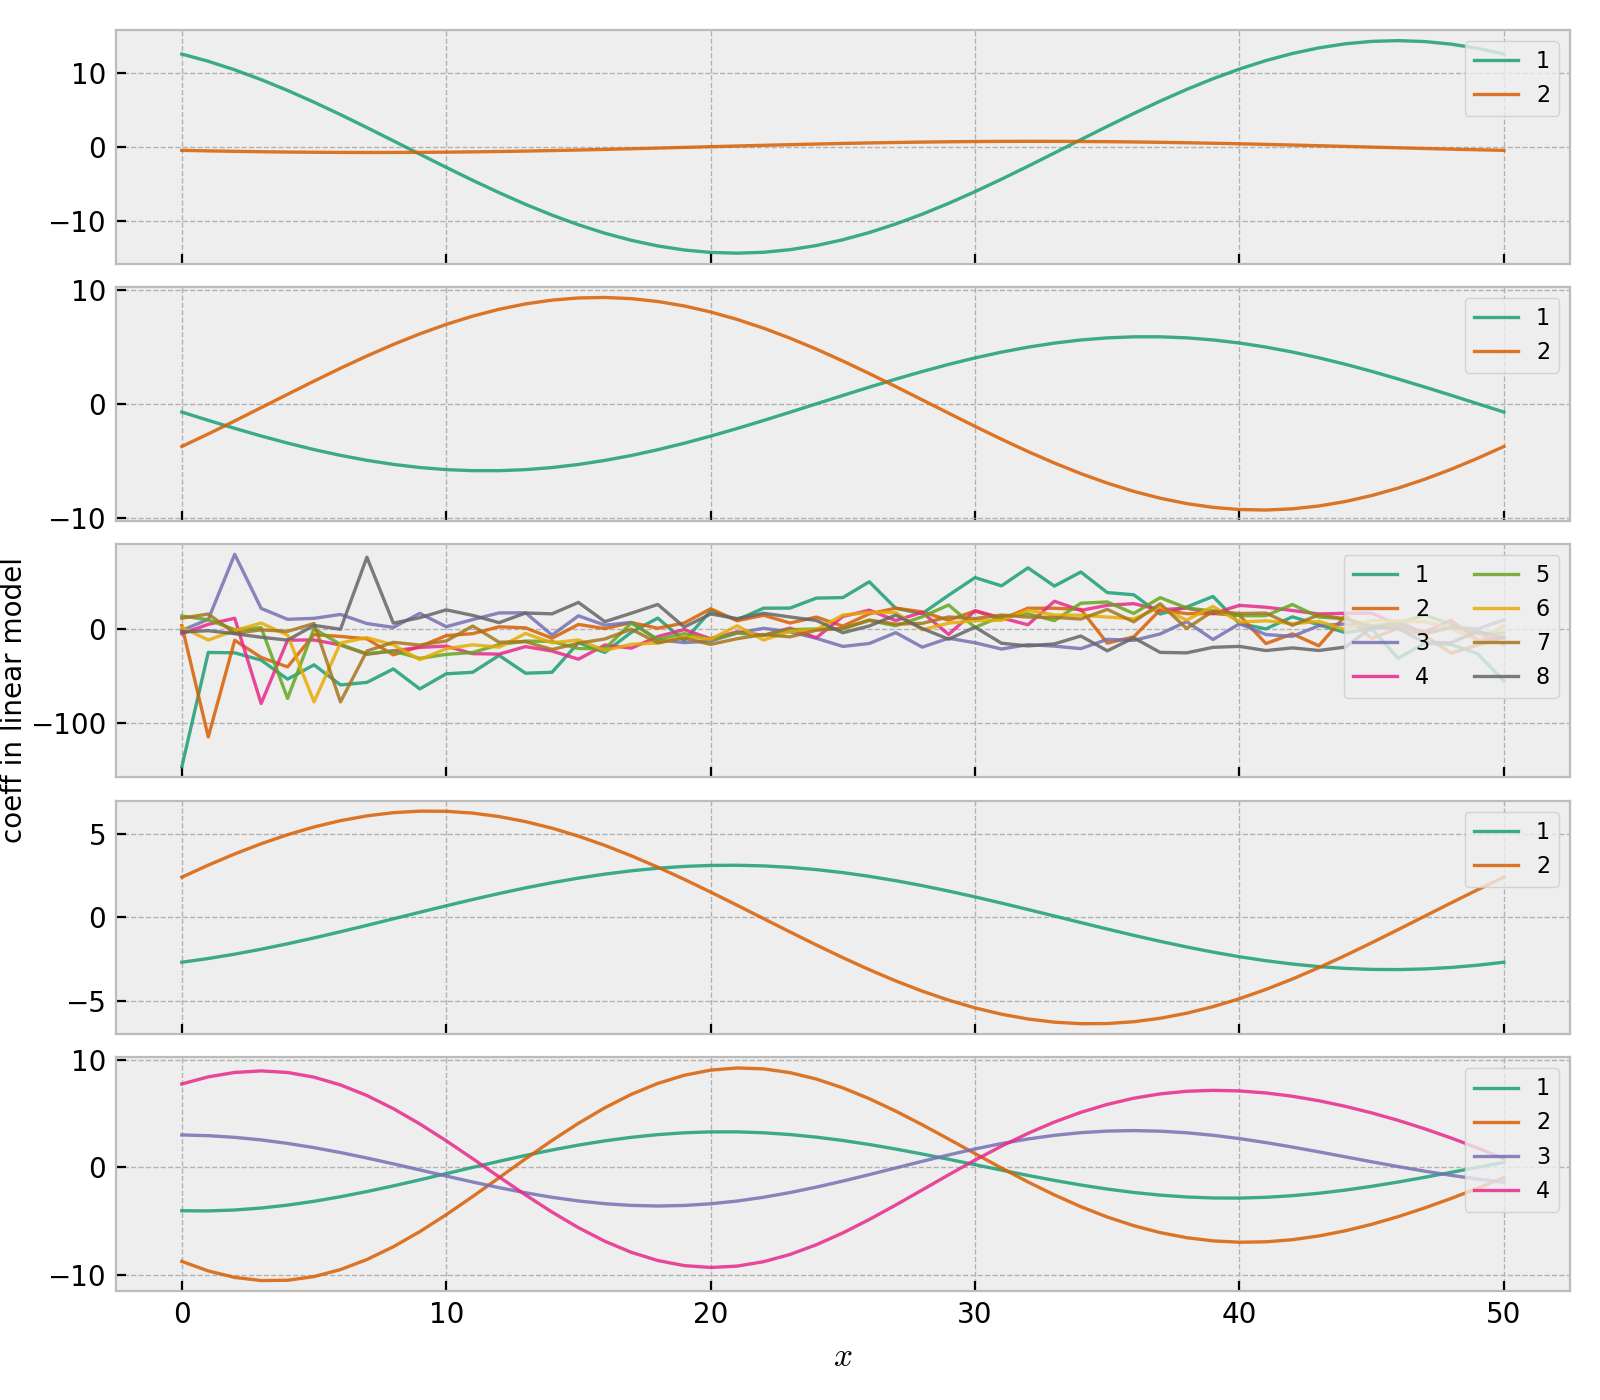

<IPython.core.display.Javascript object>


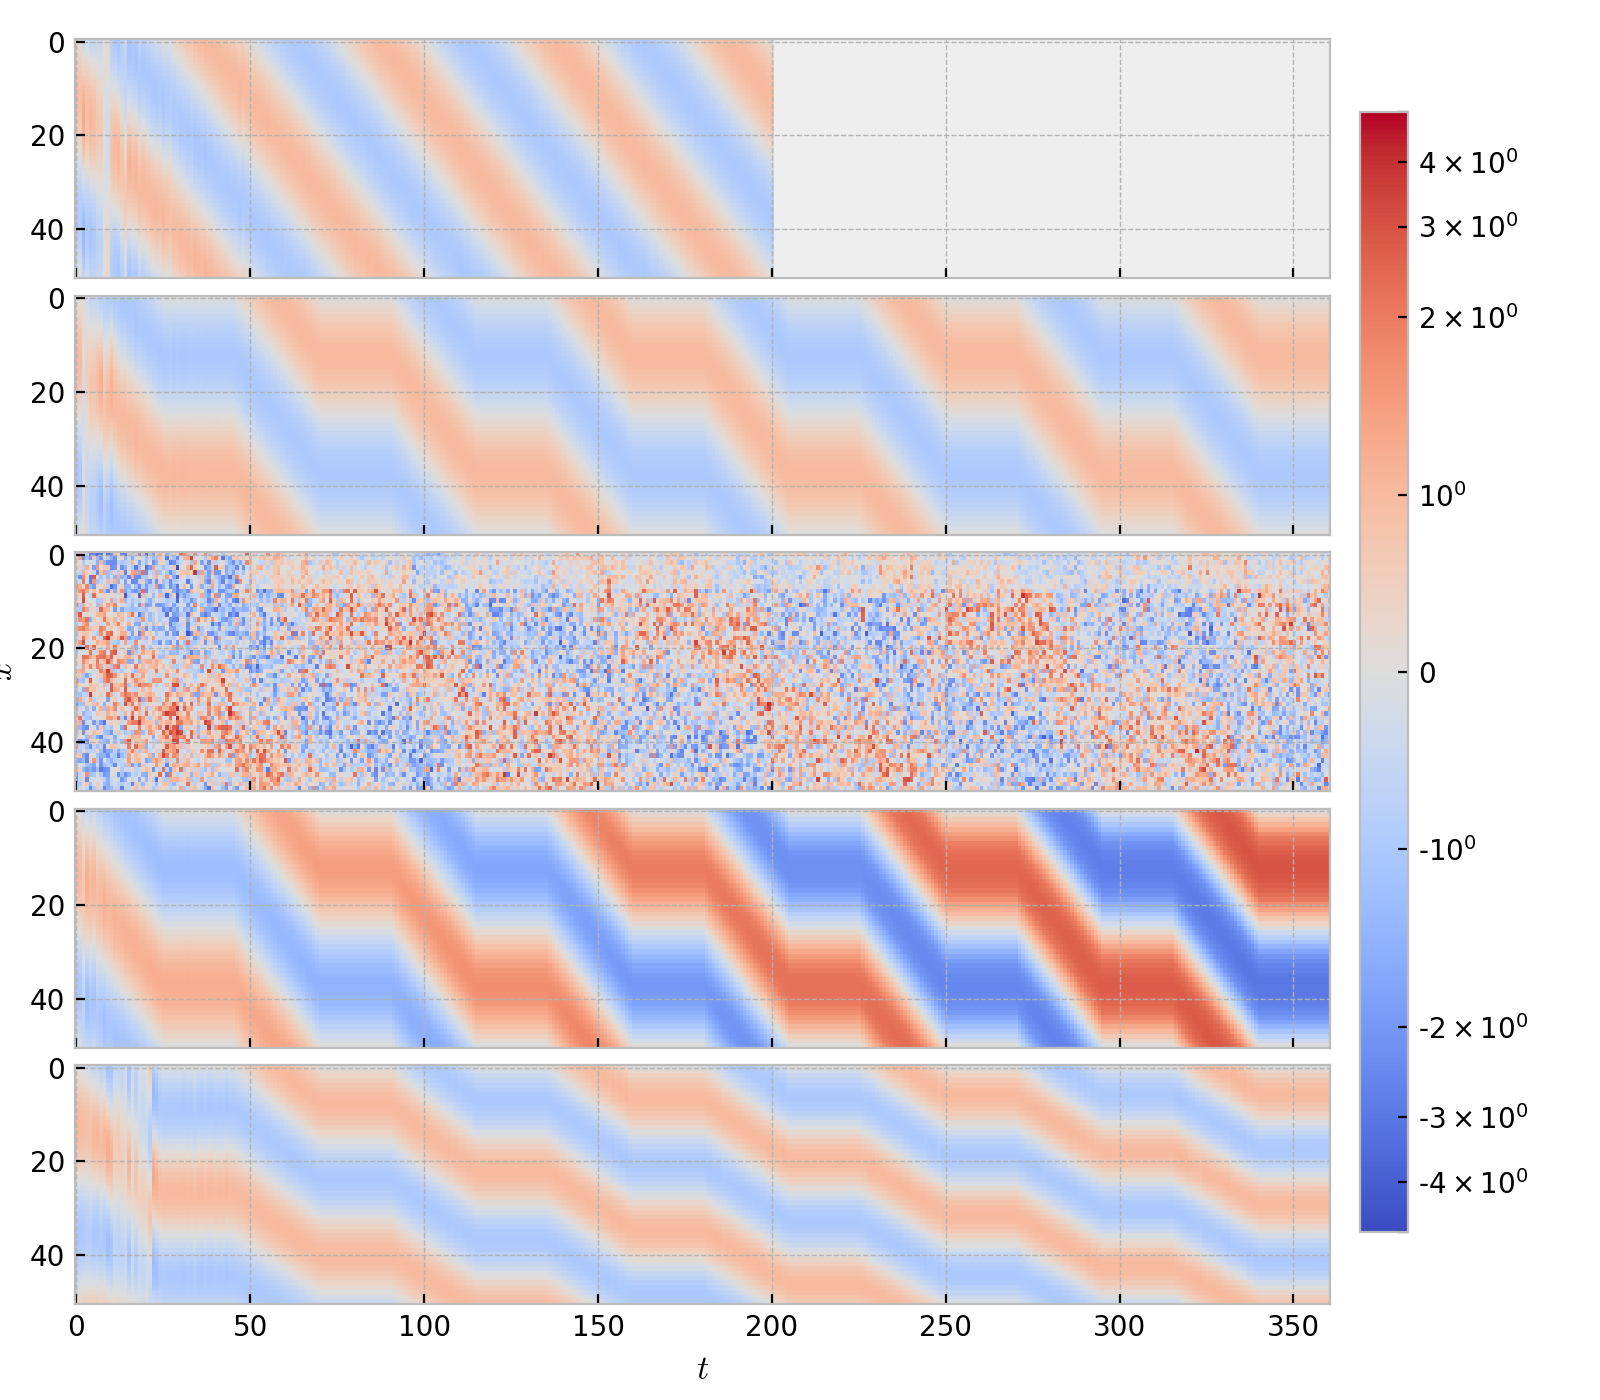

In [7]:
f2, aa = plt.subplots(len(os), 1, figsize=figsize, sharex=True, num='mlr_pcs_slopes')
f2b, aab = plt.subplots(len(os), 1, figsize=figsize, sharex=True, num='mlr_pcs_resid')

for i, o in enumerate(os):
    
    a = aab.flat[i]
    a2 = aa.flat[i]

    Y = o.dset.data.values 
    X = o.pcs[:,:o.n_retain] / np.sqrt(o.evals[:o.n_retain])
    
    #> run MLR for the ts at each x position
    fits = []
    for j in range(Y.shape[0]):
        y = Y[j,:]
        fit = sm.OLS(y, X).fit()  # model fit (coefficients etc.) for the least-squares soln
        fits.append(fit)
    resids = np.array([fit.resid for fit in fits])
    slopes = np.array([fit.params for fit in fits])
    
    #> plot slopes
    for j in range(slopes.shape[1]):
        s = '{:d}'.format(j+1)
        a2.plot(slopes[:,j], 
               c=colors[j], lw=1.2, alpha=0.85, label=s)
        
    ncol = 1 if o.n_retain <= 4 else 2
    a2.legend(loc='upper right', ncol=ncol, fontsize=leg_fs, frameon=True)        
            
    #> plot residuals as x vs t map
    im = a.imshow(resids, aspect='auto',
                  norm=mplcolors.SymLogNorm(linthresh=2, linscale=1.0, vmin=-5.0, vmax=5.0),
                  cmap='coolwarm')

#f2b.colorbar(im, orientation="vertical", pad=0.2)
f2b.tight_layout(rect=[0, 0.02, 0.85, 1.0], h_pad=hspace)  # call before adding new ax to avoid warning
cbaxes = f2b.add_axes([0.85, 0.12, 0.03, 0.8]) 
cb = f2b.colorbar(im, cax=cbaxes) 

aa[-1].set_xlabel('$x$')
f2.text(0., 0.5, 'coeff in linear model', 
        rotation='vertical', va='center')

aab[-1].set_xlabel('$t$')
aab[2].set_ylabel('$x$')

f2.tight_layout(h_pad=hspace);

## c) Plot the EOFs scaled by the square-root of their eigenvalue

This scaling...

<IPython.core.display.Javascript object>


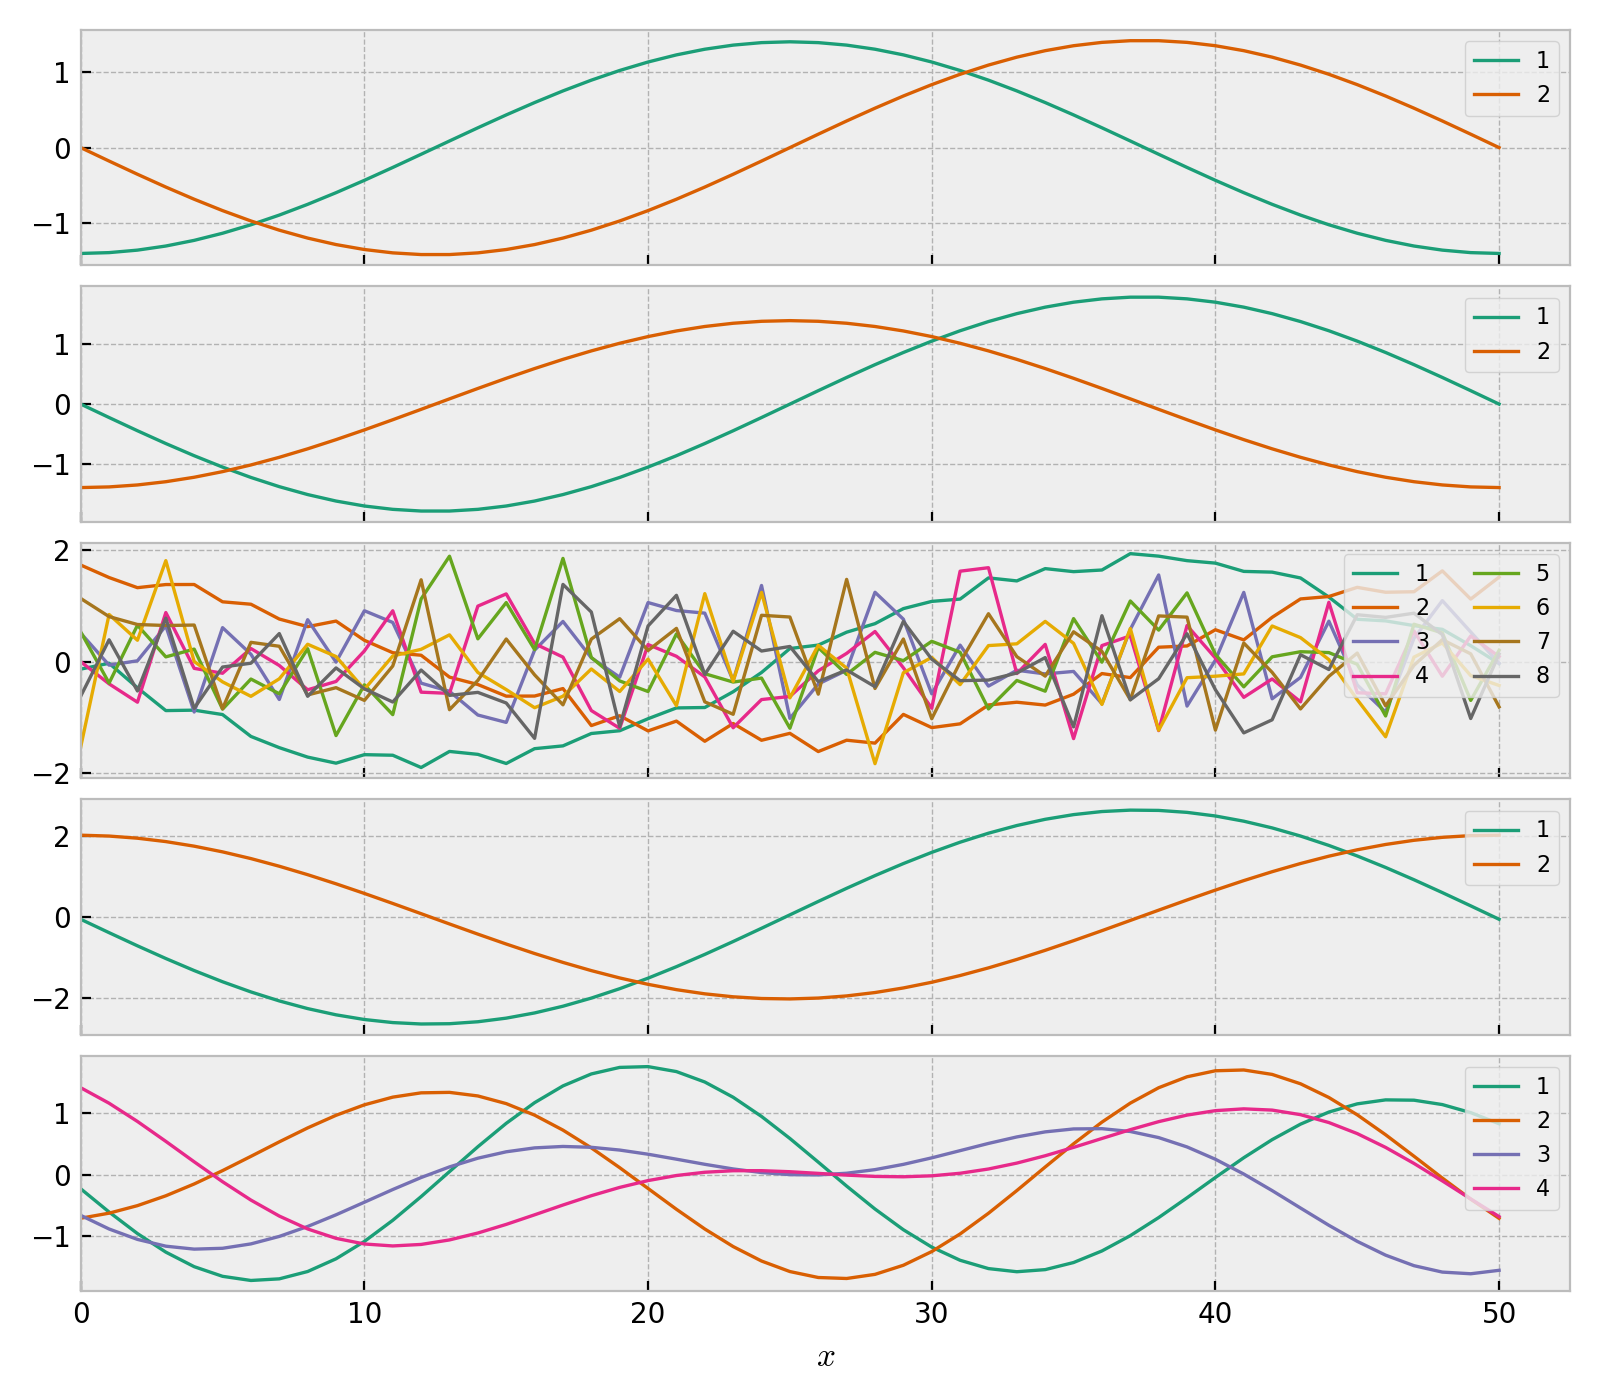

In [8]:
f3, aa = plt.subplots(len(os), 1, figsize=figsize, sharex=True, num='eofs')

for i, o in enumerate(os):
    
    a = aa.flat[i]
    
    eofs = o.evecs[:,:o.n_retain]
    evals = o.evals[:o.n_retain]
    for j in range(eofs.shape[1]):
        s = '{:d}'.format(j+1)
        a.plot(eofs[:,j]*np.sqrt(evals[j]), c=colors[j], lw=1.2, label=s)

    ncol = 1 if o.n_retain <= 4 else 2
    a.legend(loc='upper right', ncol=ncol, fontsize=leg_fs, frameon=True)        

aa[0].set_xlim(left=0)
aa[-1].set_xlabel('$x$')

f3.tight_layout(h_pad=hspace)